# Baseline Model
The purpose of this notebook is to begin modeling the train data from our previous notebook (Step1_DataCleaning_Exploration).

Objectives:

- Run model with my choice of perameters and use AUC to evaluate model performance
- Tune parameters of model to find the best fitting for data
- Repeat objective 1 until the optimal score is achieved

In [4]:
# Libraries for Data Manipulation
import numpy as np
import pandas as pd
from collections import Counter

# Library for Data Visullizations
import matplotlib.pyplot as plt
import matplotlib.colors

# Datatime Handling
import datetime

# Testing & Metrics 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

# Helper functions
from imblearn.under_sampling import RandomUnderSampler
import gc

# Model
import lightgbm as lgb

import warnings
warnings.simplefilter('ignore')

In [6]:
df = pd.read_csv('../CSV_Files/cleaned_train', index_col=0) # importing data

In [7]:
df.head() # quick view of the data 

,ip,app,device,os,channel,click_time,is_attributed,hour,day
0,83230,3,1,13,379,2017-11-06 14:32:21,0,14,6
1,17357,3,1,19,379,2017-11-06 14:33:34,0,14,6
2,35810,3,1,13,379,2017-11-06 14:34:12,0,14,6
3,45745,14,1,13,478,2017-11-06 14:34:52,0,14,6
4,161007,3,1,13,379,2017-11-06 14:35:08,0,14,6


In [8]:
df.info() # click_time did not remain as datetime so it must be changed before modeling

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
ip               int64
app              int64
device           int64
os               int64
channel          int64
click_time       object
is_attributed    int64
hour             int64
day              int64
dtypes: int64(8), object(1)
memory usage: 762.9+ MB


In [9]:
df.shape # quick view of how large the data is

(10000000, 9)

# Quick Alterations
Before we begin the modeling process as you can see the click_time column is still a string vs a datetimes64 [ns]. This is just one small but important example as to why you need to look at your data even after you have cleaned and transformed it.  

In [10]:
df['click_time'] = pd.to_datetime(df['click_time']) # set click_time as timeseries

In [11]:
df.info() # checking my work

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
ip               int64
app              int64
device           int64
os               int64
channel          int64
click_time       datetime64[ns]
is_attributed    int64
hour             int64
day              int64
dtypes: datetime64[ns](1), int64(8)
memory usage: 762.9 MB


# Train Test Split 

In [12]:
# setting my target and and df to run test on and with
X= df.drop(columns=['is_attributed', 'click_time'])
y= df['is_attributed']

In [13]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

Side note: the parameter stratify is being used becasue we have an imbalanced dataset. It deals with this type of data by spliting the data in a way to where the proportion of the sampled values matches the proportion of the values given to the stratify parameter, in our case our target. Check resource section of notebook for more information. 

# Baseline Model: Model 1 
Remember I just want a baseline to see where I'm starting, so the parameters will be set based off of the type of problem we are dealing with; binary classification. Se recource section for more information on model and parameter selection. Lets fit the model onto the train data and see how well it does using the AUC metric.

In [14]:
# converting training data into LightGBM dataset format
# mandatory for using lgb, see blog link in resource section 
df_train = lgb.Dataset(X_train, label=y_train) 

In [15]:
df_train # what the dataset has turned into 

In [16]:
# the parameters I choice for this dataset, see blog link in resource section 
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['application'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 50
params['max_depth'] = 10
params['bagging_fraction'] = 0.5
clf = lgb.train(params, df_train) # training model on parameters and train data

In [17]:
y_pred=clf.predict(X_test) # assigning model predictions to variable to be called later

In [18]:
roc_auc = roc_auc_score(y_test,y_pred) # checking how well the model scored 
print("ROC AUC Score: {}".format(roc_auc))

ROC AUC Score: 0.9446001248781845


# Quick Observation
From what the results show this model is about 94% confident in predicting if an app is downloaded or not. What I would like to do next is conduct a grid search to find the best parameters for this model and classification problem. Being that this is such a large dataset, that will take up time I do not have for this project. So what I will have to do is down sample the data to a smaller portion that will take a shorter period of time to run a grid search. Please see resource section of notebook for further information on the medeling of this data (winner of competition strategy).

# Down Sampling 
Below this markdown cell you will see the imbalance in the data when it comes to app downloads vs non downloads. We want to make them value count of each match up. To down sample I will make the values that are dominant in the column equal to the values that are least dominant in this column. After speaking with our DS 02172020 Lead Instructor Bryan Arnold, a function shown to me that can downsample the data for me vs writing a custom function!!!

In [19]:
y.value_counts() # view of the imbalance in the target

0    9981283
1      18717
Name: is_attributed, dtype: int64

In [20]:
# downsampling and printing out the results 
rus = RandomUnderSampler(random_state=42) 
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 18717, 1: 18717})


# Train Test Split On Balanced Data
This must be done but to the new X and y from the above cell. X_res, y_res.

In [21]:
X_res.shape # just looking at the data shape

(37434, 7)

In [22]:
y_res.shape # just looking at the data shape

(37434,)

In [23]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state = 0)
# taking out stratify parameter because data is now balanced 

# Saving Downsampled Data To CSv File

In [24]:
# df_sample = pd.DataFrame(X_res, columns=['ip', 'app', 'device', 'os', 'channel', 'hour', 'day'])
# df_sample['target'] = y_res

In [25]:
# df_sample.to_csv('sample_csv.csv', index=False)

# GridSearch: Model 4320
Now that I have a smaller dataset to deal with after downsampling, I can now perform a grid search to find the best parameters for modeling this dataset. 

In [26]:
'''See resource section to find a blog post with this code. 
This function will take in the train test split data, lbg model, parameters to filter through for lbg,
cross validate the data 10 times, score the data using AUC metric, 
without performing any probabilities as its arguments

What it will return when given the parameters it needs, will be the AUC score of the best fitting parameters for 
the dataset
'''
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [27]:
'''Below I am creating a variable to hold the model for the function in the previous cell. I am also creating a 
dictionary of parameters that will be used in the gridsearch. Once the model and parameters are set I am then 
calling the function with the needed arguments. Once the function is done running I will recieve an AUC score 
and the list of parameters that got me that score.
See resource section for more info on the code below.'''

model = lgb.LGBMClassifier() # model I am using

# parameters I chose to try for gridsearch
param_grid = {
'n_estimators': [400, 700, 1000],
'learning_rate': [0.003], 
'boosting_type': ['gbdt', 'rf'],
'application':['binary'], 
'metric': ['auc', 'binary_logloss'],
'num_leaves': [50, 100, 200],
'min_data': [50,100],
'max_depth': [15, 20, 25],
'bagging_fraction': [0.5, 1, 5, 7]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5, scoring_fit='roc_auc') # calling the function

# printing resuts of the gridsearch and the score
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 686 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 1257 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 1702 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 37.4min finished


0.9537882530559942
{'application': 'binary', 'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'learning_rate': 0.003, 'max_depth': 15, 'metric': 'auc', 'min_data': 50, 'n_estimators': 1000, 'num_leaves': 50}


# Quick Observation
ROC AUC Score: 0.9446001248781845 was our score before balancing the data and a spesific list of parameters. After running through 4320 different models, now the model is scoring ROC AUC Score: 0.9537882530559942, due to a gridsearch that found the best fitting parameters. Before I move on, I want to try another set of parameters to see how the model does. Below you will see a new dictionary of parameters, see resource section for more info on the code below. 

# Model 4321

In [28]:
# trying a new set of parameters 
param_grid2 = {
'learning_rate': [0.10],
'num_leaves': [7],  
'max_depth': [3],  
'min_child_samples': [100], 
'max_bin': [100],  
'subsample': [0.7], 
'subsample_freq': [1],  
'colsample_bytree': [0.9],  
'min_child_weight': [0],  
'scale_pos_weight':[200]} 

In [29]:
# converting new (balanced data) training data into LightGBM dataset format
# mandatory for using lgb, see blog link in resource section 
df_train2 = lgb.Dataset(X_train, label=y_train, feature_name=['ip', 'app', 'device', 'os', 'channel', 'hour', 'day']
                       ) 


clf = lgb.train(params, df_train2) # training model on new parameters and balanced train data

In [30]:
y_pred=clf.predict(X_test) # assigning model predictions to variable to be called later

In [31]:
roc_auc = roc_auc_score(y_test,y_pred) # checking how well the model scored 
print("ROC AUC Score: {}".format(roc_auc))

ROC AUC Score: 0.9554002673539395


# Feature Importance
When determining fraudulent and non fraudulent clicks, what are the most important features/ columns in the data?

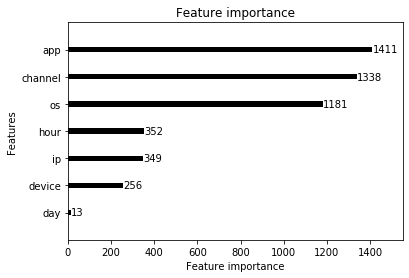

In [32]:
ax = lgb.plot_importance(clf, max_num_features=10, grid=False, color='black') # plotting feature importance for lgb
# plt.savefig('fi.png', transparent= True) # saving plot as image without white background
plt.show()

# Conclusion 
The last version of my model did great! 0.955 Score For AUC is as far as I could get with the time frame that we had on this project. Future recommendations I have would be to gather more data, more data is always good. This will help me teach the model more about patterns in the data. I would also follow in the foot steps of the TalkData competition winners & pull more features from the click time column, in this project I only had two features I pulled from the click time column, but with more time and research I could have pulled more, which would have helped my model learn more patterns to help identify fraudulent behavior in the data. 

# Resources

Code for importing lgb: https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680


Parameter Tuning for lgb: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html


Blog and code on lgb: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc


Strategy of TalkingData AdTracking Fraud Detection Challenge Winner: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56475?rvi=1


Explanation of train tes split parameter stratify: https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn (The second answer has a short explanation)


Down Sampling: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler


GridSearch function on lgb: https://mlfromscratch.com/gridsearch-keras-sklearn/#/


Parameter Grid 2: https://www.kaggle.com/asraful70/notebook-version-of-talkingdata-lb-0-9786


Plotting Feature Importance for lgb: https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html#plot_importance